In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

## No Exercise - problem of inversion 

In [93]:
path="/mnt/rmn_files/0_Wip/New/1_Methodological_Developments/1_Methodologie_3T/#6_2024_RespiMRF/2_Data_Raw/Spherical/exercice"

# file=f"{path}/meas_MID00202_FID63497_raFin_3D_tra_1_5x1_5x1_5mm_mrf_optim_kushball_exercice"
file=f"{path}/meas_MID00201_FID63496_raFin_3D_tra_1_5x1_5x1_5mm_mrf_optim_kushball"
disp=np.load(file+"_displacement.npy")
bins=np.load(file+"_bins.npy")
image_nav=np.load(file+"_image_nav.npy")

Text(0.5, 1.0, 'Displacement Over Time')

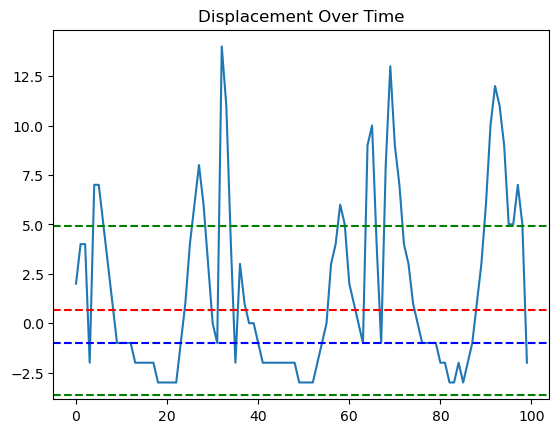

In [33]:
mean=np.mean(disp)
std=np.std(disp)
median=np.median(disp)
plt.plot(disp[:100])
plt.axhline(mean, color='r', linestyle='--', label='Mean')
plt.axhline(median, color='b', linestyle='--', label='Median')
plt.axhline(mean + std, color='g', linestyle='--', label='Mean + 1 Std Dev')
plt.axhline(mean - std, color='g', linestyle='--', label='Mean - 1 Std Dev')
plt.title('Displacement Over Time')

In [56]:
npoint_nav=image_nav.shape[-1]
ch=31

In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
nb_gating_spokes=image_nav.shape[2]

image_reshaped = image_nav[ch].reshape(-1, npoint_nav)
decomposition = seasonal_decompose(image_reshaped,
                                           model='multiplicative', period=nb_gating_spokes)
image_nav_adj=image_reshaped/decomposition.seasonal
image_nav_adj=image_nav_adj.reshape(-1,nb_gating_spokes,npoint_nav)


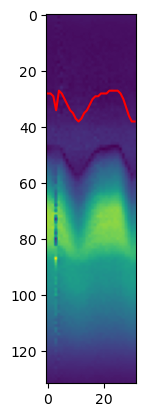

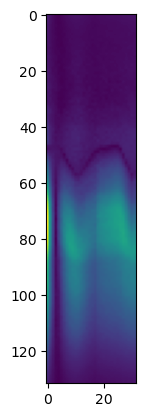

In [58]:
start=5
nb_cycles=1
disp_start=start*nb_gating_spokes
disp_end=disp_start+nb_cycles*nb_gating_spokes
disp_count=32
plt.imshow(np.abs(image_nav_adj.reshape(-1,npoint_nav)[disp_start:disp_end]).T)
plt.plot(30+disp[disp_start:disp_end], color='r')

plt.figure()
plt.imshow(np.abs(image_nav[ch].reshape(-1,npoint_nav)[disp_start:disp_end]).T)

In [106]:
from tqdm import tqdm
from copy import copy
bottom=-20
top=45
max_correl_for_interp=0.9
randomize=True
dct_frequency_filter=None
shifts=list(range(bottom, top))
lambda_tv=0

In [95]:
image=image_nav_adj

nb_gating_spokes = image.shape[1]
nb_slices = image.shape[0]
npoint_image = image.shape[-1]


all_images = image
if randomize:
    image_reshaped=image.reshape(-1, npoint_image)
    for ind in range(2, nb_gating_spokes):
        shifted_image = np.concatenate([image_reshaped[ind:], image_reshaped[:ind]],
                                       axis=0).reshape(nb_slices, nb_gating_spokes, -1)
        all_images = np.concatenate([all_images, shifted_image], axis=0)

ft = np.mean(all_images, axis=0)
    # ft=np.mean(image_nav_best_channel,axis=0)
    # ft=image[0]


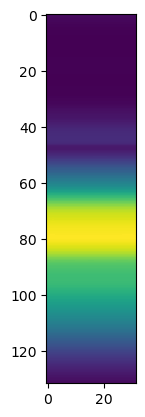

In [96]:
ft.shape
plt.imshow(np.abs(ft).T)

In [97]:
image_nav_for_correl = image.reshape(-1, npoint_image)
nb_images = image_nav_for_correl.shape[0]
max_correl=0
max_correls = []
mvt = []
all_correls=[]
for j in tqdm(range(nb_images)):
    if (j % nb_gating_spokes == 0)or(max_correl<0.5):
        used_shifts=shifts
    else:
        used_shifts=np.arange(mvt[j - 1]-10,(mvt[j - 1]+10)).astype(int)
        # print(used_shifts)
    corrs = np.zeros(len(used_shifts))
    bottom = np.maximum(-used_shifts[0],int(npoint_image/4))
    top = np.minimum(int(npoint_image) -used_shifts[-1],int(3*npoint_image/4))
    # print(bottom)
    # print(top)
    for i, shift in enumerate(used_shifts):
            
        corr = np.corrcoef(np.concatenate([ft[j % nb_gating_spokes, bottom:top].reshape(1, -1),
                                               image_nav_for_correl[j, (bottom + shift):(top + shift)].reshape(1, -1)],
                                              axis=0))[0, 1]
            # corr = np.linalg.norm(image_nav_for_correl[0, bottom:top]-image_nav_for_correl[j + 1, (bottom + shift):(top + shift)])
        corrs[i] = corr
        # adjustment=np.sum(dft_x[j+1]*dft_t[j])/np.sum(dft_x[j+1]**2)
        # adj.append(adjustment)
    if (j % nb_gating_spokes == 0):
        J = corrs


    else:
        J = corrs - lambda_tv * (np.array(used_shifts) - mvt[j - 1]) ** 2  # penalty to not be too far from last disp
    all_correls.append(corrs)
    ind_max_J=np.argmax(J)
    current_mvt = used_shifts[ind_max_J]
    max_correl=J[ind_max_J]
    max_correls.append(max_correl)
    mvt.append(current_mvt)



100%|██████████| 5440/5440 [00:02<00:00, 1882.80it/s]


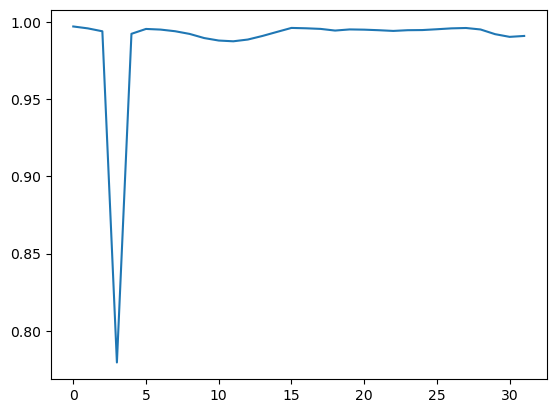

In [98]:
max_correls=np.array(max_correls)
plt.plot(max_correls[disp_start:disp_end])


In [99]:
displacement = np.array(mvt)
max_correls=np.array(max_correls)
if dct_frequency_filter is not None:
    displacements_reshaped = displacement.reshape(nb_slices, nb_gating_spokes)
    displacements_smooth = np.zeros_like(displacements_reshaped)
    for sl in range(nb_slices):
        transf_disp = sp.fft.dct(displacements_reshaped[sl])
        transf_disp[-dct_frequency_filter:] = 0
        displacements_smooth[sl] = sp.fft.idct(transf_disp)
    displacement = displacements_smooth.flatten()


In [164]:

if max_correl_for_interp is not None:
    ind_bad_correl=np.argwhere(max_correls<max_correl_for_interp)
    displacement_new=copy(displacement)
    for i in ind_bad_correl.flatten():
        if ((np.abs(displacement[i]-displacement[i-1])/np.abs(displacement[i])>0.5)and(np.abs(displacement[i]-displacement[i+1])/np.abs(displacement[i])>0.5)):
            displacement_new[i]=np.mean([displacement[i-1],displacement[i+1]])


/tmp/ipykernel_638480/3435642885.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  if ((np.abs(displacement[i]-displacement[i-1])/np.abs(displacement[i])>0.5)and(np.abs(displacement[i]-displacement[i+1])/np.abs(displacement[i])>0.5)):
/tmp/ipykernel_638480/3435642885.py:5: RuntimeWarning: invalid value encountered in long_scalars
  if ((np.abs(displacement[i]-displacement[i-1])/np.abs(displacement[i])>0.5)and(np.abs(displacement[i]-displacement[i+1])/np.abs(displacement[i])>0.5)):


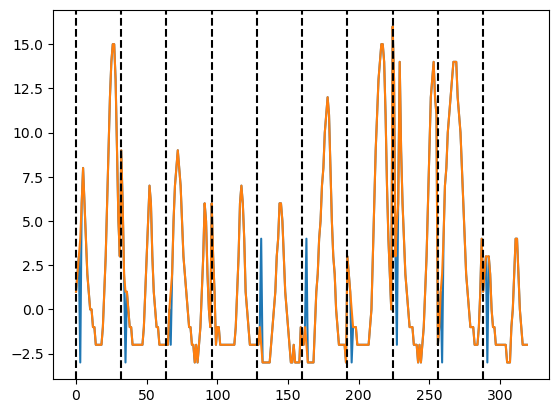

In [ ]:
start_cycle=np.random.randint(0,nb_slices)
nb_cycles=10
disp_start=start_cycle*nb_gating_spokes
disp_end=disp_start+nb_cycles*nb_gating_spokes
plt.plot(displacement[disp_start:disp_end])
plt.plot(displacement_new[disp_start:disp_end])
for j in range(nb_cycles):

    plt.axvline(j*nb_gating_spokes, color='k', linestyle='--')

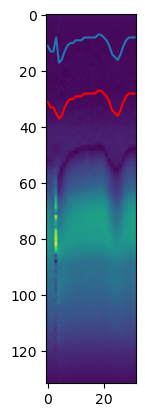

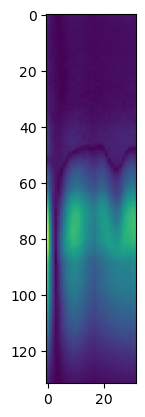

In [111]:
start_cycle=np.random.randint(0,nb_slices)
nb_cycles=1
disp_start=start_cycle*nb_gating_spokes
disp_end=disp_start+nb_cycles*nb_gating_spokes

plt.imshow(np.abs(image_nav_adj.reshape(-1,npoint_nav)[disp_start:disp_end]).T)
plt.plot(10+displacement[disp_start:disp_end])
plt.plot(30+displacement_new[disp_start:disp_end], color='r')

plt.figure()
plt.imshow(np.abs(image_nav[ch].reshape(-1,npoint_nav)[disp_start:disp_end]).T)

TODO : Fix code using max correl of 0.9

## Exercise - look at outliers

In [513]:
path="/mnt/rmn_files/0_Wip/New/1_Methodological_Developments/1_Methodologie_3T/#6_2024_RespiMRF/2_Data_Raw/Spherical/exercice"

file=f"{path}/meas_MID00202_FID63497_raFin_3D_tra_1_5x1_5x1_5mm_mrf_optim_kushball_exercice"
# file=f"{path}/meas_MID00201_FID63496_raFin_3D_tra_1_5x1_5x1_5mm_mrf_optim_kushball"

disp=np.load(file+"_displacement.npy")
bins=np.load(file+"_bins.npy")
image_nav=np.load(file+"_image_nav.npy")

Text(0.5, 1.0, 'Displacement Over Time')

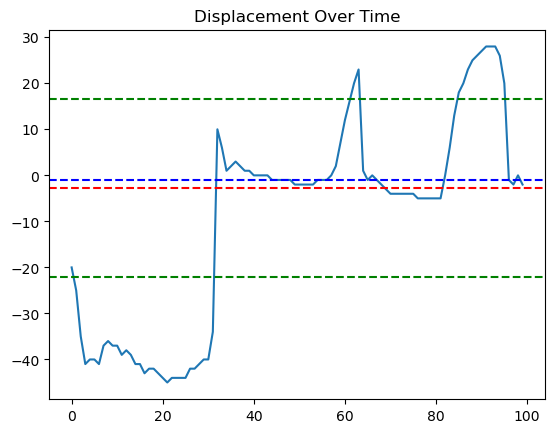

In [514]:
mean=np.mean(disp)
std=np.std(disp)
median=np.median(disp)
plt.plot(disp[:100])
plt.axhline(mean, color='r', linestyle='--', label='Mean')
plt.axhline(median, color='b', linestyle='--', label='Median')
plt.axhline(mean + std, color='g', linestyle='--', label='Mean + 1 Std Dev')
plt.axhline(mean - std, color='g', linestyle='--', label='Mean - 1 Std Dev')
plt.title('Displacement Over Time')

In [515]:
npoint_nav=image_nav.shape[-1]
ch=31

In [516]:
from statsmodels.tsa.seasonal import seasonal_decompose
nb_gating_spokes=image_nav.shape[2]

image_reshaped = image_nav[ch].reshape(-1, npoint_nav)
decomposition = seasonal_decompose(image_reshaped,
                                           model='multiplicative', period=nb_gating_spokes)
image_nav_adj=image_reshaped/decomposition.seasonal
image_nav_adj=image_nav_adj.reshape(-1,nb_gating_spokes,npoint_nav)


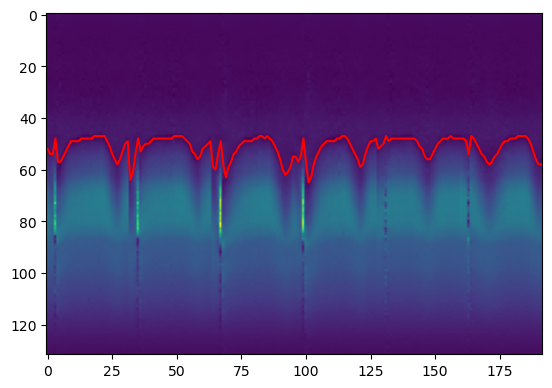

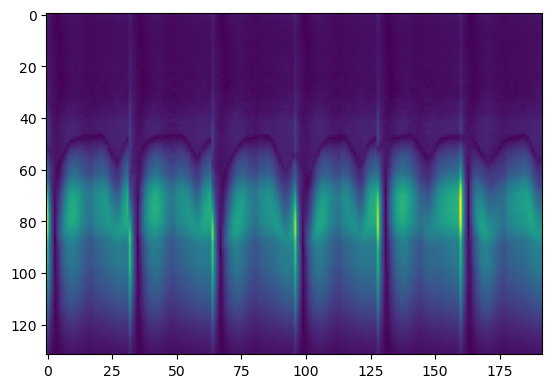

In [451]:
start=0
nb_cycles=6
disp_start=start*nb_gating_spokes
disp_end=disp_start+nb_cycles*nb_gating_spokes
disp_count=32
plt.imshow(np.abs(image_nav_adj.reshape(-1,npoint_nav)[disp_start:disp_end]).T)
plt.plot(50+disp[disp_start:disp_end], color='r')

plt.figure()
plt.imshow(np.abs(image_nav[ch].reshape(-1,npoint_nav)[disp_start:disp_end]).T)

In [354]:
from tqdm import tqdm
from copy import copy
min_shift=-40
max_shift=40
pad=0
max_correl_for_interp=0.8
randomize=True
dct_frequency_filter=None
shifts=list(range(min_shift, max_shift))
bottom = np.maximum(-min_shift,int(npoint_nav/6))
top = np.minimum(int(npoint_nav + 2*pad) - max_shift,int(5*npoint_nav/5))
# shifts=list(range(-bottom, top))

lambda_tv=0

In [355]:
shifts

[-40,
 -39,
 -38,
 -37,
 -36,
 -35,
 -34,
 -33,
 -32,
 -31,
 -30,
 -29,
 -28,
 -27,
 -26,
 -25,
 -24,
 -23,
 -22,
 -21,
 -20,
 -19,
 -18,
 -17,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

In [517]:
image=image_nav_adj

nb_gating_spokes = image.shape[1]
nb_slices = image.shape[0]
npoint_image = image.shape[-1]


all_images = image
if randomize:
    image_reshaped=image.reshape(-1, npoint_image)
    for ind in range(2, nb_gating_spokes):
        shifted_image = np.concatenate([image_reshaped[ind:], image_reshaped[:ind]],
                                       axis=0).reshape(nb_slices, nb_gating_spokes, -1)
        all_images = np.concatenate([all_images, shifted_image], axis=0)

ft = np.mean(all_images, axis=0)
    # ft=np.mean(image_nav_best_channel,axis=0)
    # ft=image[0]


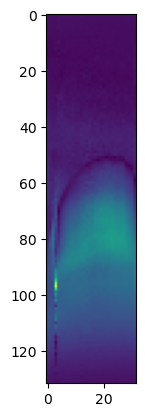

In [357]:
plt.imshow(image_nav_adj[0].T)

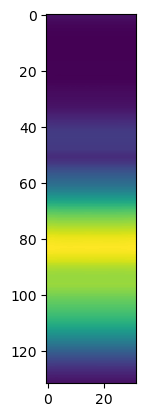

In [358]:
ft.shape
plt.imshow(np.abs(ft).T)

In [359]:
used_shifts
print(bottom)
print(top)

print(int(npoint_image/4))
print(int(3*npoint_image/4))

40
92
33
99


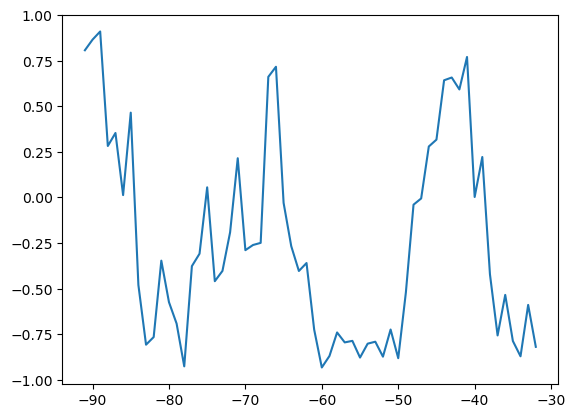

In [351]:
plt.plot(all_shifts[-1],all_correls[-1])

In [353]:
j%nb_gating_spokes

7

In [363]:
image_nav_for_correl = image.reshape(-1, npoint_image)
nb_images = image_nav_for_correl.shape[0]
max_correl=0
max_correls = []
mvt = []
all_correls=[]
all_shifts=[]
for j in tqdm(range(nb_images)):
    if (j % nb_gating_spokes == 0)or(max_correl<0.5):
        used_shifts=shifts
    else:
        used_shifts=np.arange(mvt[j - 1]-30,(mvt[j - 1]+30)).astype(int)
        # used_shifts=shifts
        # print(used_shifts)
    corrs = np.zeros(len(used_shifts))
    bottom = np.maximum(-used_shifts[0],int(npoint_image/6))
    top = np.minimum(int(npoint_image) -used_shifts[-1],int(5*npoint_image/6))
    # print(bottom)
    # print(top)
    for i, shift in enumerate(used_shifts):
            
        corr = np.corrcoef(np.concatenate([ft[j % nb_gating_spokes, bottom:top].reshape(1, -1),
                                               image_nav_for_correl[j, (bottom + shift):(top + shift)].reshape(1, -1)],
                                              axis=0))[0, 1]
            # corr = np.linalg.norm(image_nav_for_correl[0, bottom:top]-image_nav_for_correl[j + 1, (bottom + shift):(top + shift)])
        corrs[i] = corr
        # adjustment=np.sum(dft_x[j+1]*dft_t[j])/np.sum(dft_x[j+1]**2)
        # adj.append(adjustment)
    if (j % nb_gating_spokes == 0):
        J = corrs


    else:
        J = corrs - lambda_tv * (np.array(used_shifts) - mvt[j - 1]) ** 2  # penalty to not be too far from last disp
    all_correls.append(corrs)
    ind_max_J=np.argmax(J)
    current_mvt = used_shifts[ind_max_J]
    max_correl=J[ind_max_J]
    max_correls.append(max_correl)
    mvt.append(current_mvt)
    all_shifts.append(used_shifts)



100%|██████████| 5440/5440 [00:09<00:00, 561.38it/s]


In [ ]:
help(np.convolve)

83

In [440]:
ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)].shape

(31,)

0
2


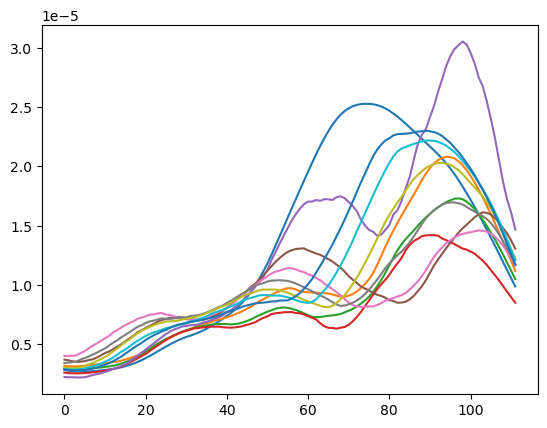

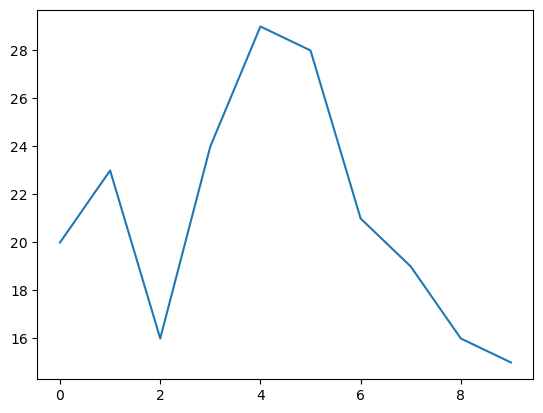

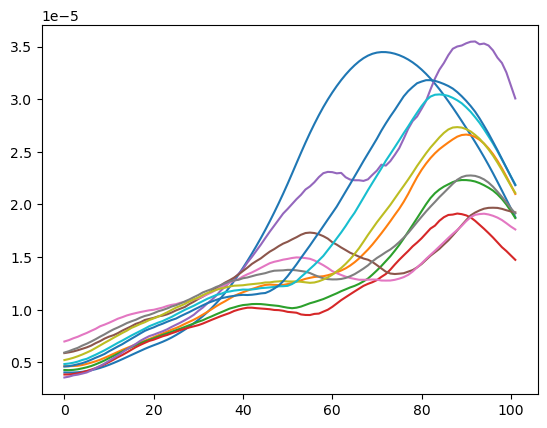

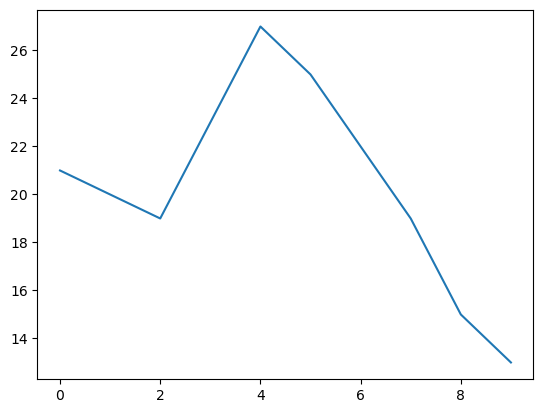

In [441]:
center_pattern=np.argmax(ft[0,:])
width_pattern=10
disp_test=[]
plt.plot(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],ft[0],mode='valid'))
print(np.argmax(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],ft[0],mode='valid'))-center_pattern+width_pattern-1)
for j in range(10):
    plt.plot(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],image_nav_for_correl[4*nb_gating_spokes+j],mode='valid'))
    disp_test.append(np.argmax(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],image_nav_for_correl[4*nb_gating_spokes+j],mode='valid'))-center_pattern+width_pattern-1)

plt.figure()
plt.plot(disp_test)

plt.figure()
center_pattern=np.argmax(ft[0,:])
width_pattern=15
disp_test=[]
plt.plot(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],ft[0],mode='valid'))
print(np.argmax(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],ft[0],mode='valid'))-center_pattern+width_pattern-1)
for j in range(10):
    plt.plot(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],image_nav_for_correl[4*nb_gating_spokes+j],mode='valid'))
    disp_test.append(np.argmax(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],image_nav_for_correl[4*nb_gating_spokes+j],mode='valid'))-center_pattern+width_pattern-1)

plt.figure()
plt.plot(disp_test)



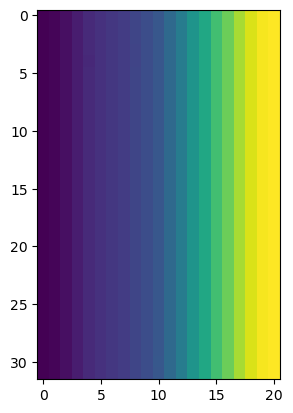

In [446]:
plt.imshow(ft[:,center_pattern-width_pattern:center_pattern+(width_pattern+1)])

-3
46


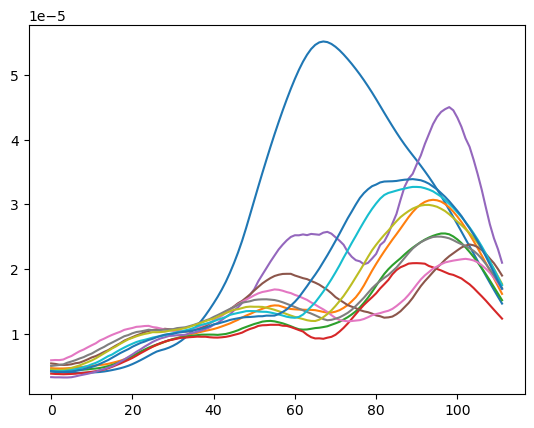

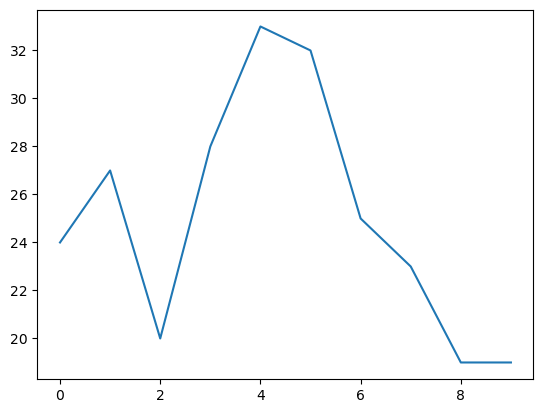

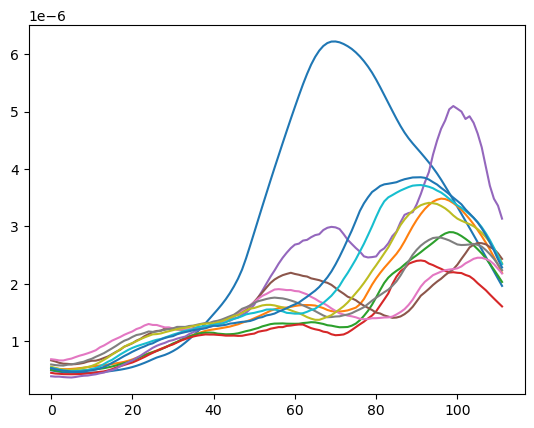

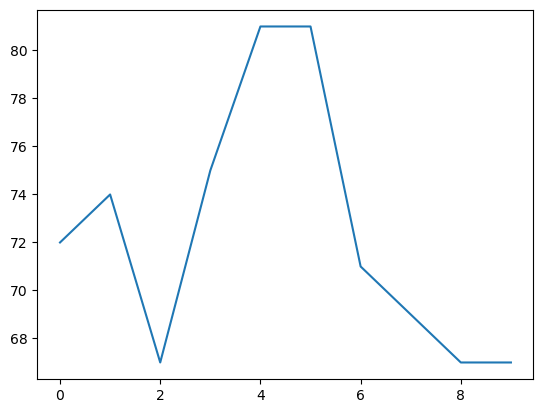

In [453]:
center_pattern=np.argmax(ft[0,:])
width_pattern=10
disp_test=[]
plt.plot(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],ft[0],mode='valid'))
print(np.argmax(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],ft[0],mode='valid'))-center_pattern+width_pattern-1)
for j in range(10):
    plt.plot(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],image_nav_for_correl[4*nb_gating_spokes+j],mode='valid'))
    disp_test.append(np.argmax(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],image_nav_for_correl[4*nb_gating_spokes+j],mode='valid'))-center_pattern+width_pattern-1)

plt.figure()
plt.plot(disp_test)

plt.figure()
center_pattern=npoint_image//4
width_pattern=10
disp_test=[]
plt.plot(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],ft[0],mode='valid'))
print(np.argmax(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],ft[0],mode='valid'))-center_pattern+width_pattern-1)
for j in range(10):
    plt.plot(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],image_nav_for_correl[4*nb_gating_spokes+j],mode='valid'))
    disp_test.append(np.argmax(np.convolve(ft[0,center_pattern-width_pattern:center_pattern+(width_pattern+1)],image_nav_for_correl[4*nb_gating_spokes+j],mode='valid'))-center_pattern+width_pattern-1)

plt.figure()
plt.plot(disp_test)

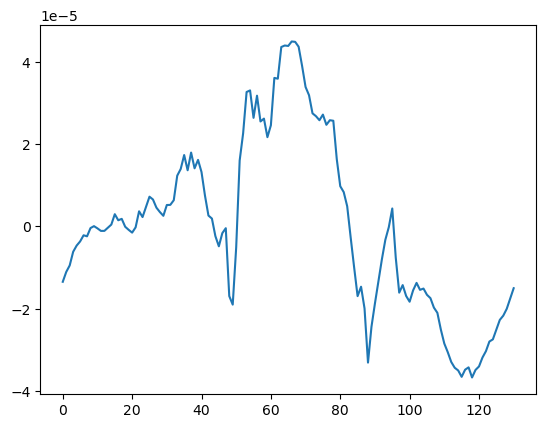

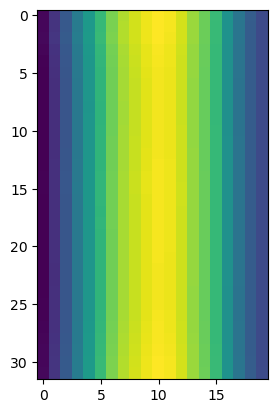

In [518]:
plt.plot(np.diff(ft[0]))

center_pattern=np.argmax(ft[0,:])
width_pattern=10

pattern=ft[0,center_pattern-width_pattern:center_pattern+width_pattern]

plt.figure()
plt.imshow(ft[:,center_pattern-width_pattern:center_pattern+width_pattern])

In [519]:
image_nav_for_correl = image.reshape(-1, npoint_image)
nb_images = image_nav_for_correl.shape[0]
max_correl=0
max_correls = []
mvt = []
all_correls=[]
all_shifts=[]

for j in tqdm(range(nb_images)):
    
    corrs=np.convolve(pattern,image_nav_for_correl[j],mode='valid')

    J=corrs
    
    all_correls.append(corrs)
    ind_max_J=np.argmax(J)
    current_mvt = ind_max_J - npoint_image//2
    max_correl=J[ind_max_J]
    max_correls.append(max_correl)
    mvt.append(current_mvt)
    all_shifts.append(used_shifts)

100%|██████████| 5440/5440 [00:00<00:00, 273621.39it/s]


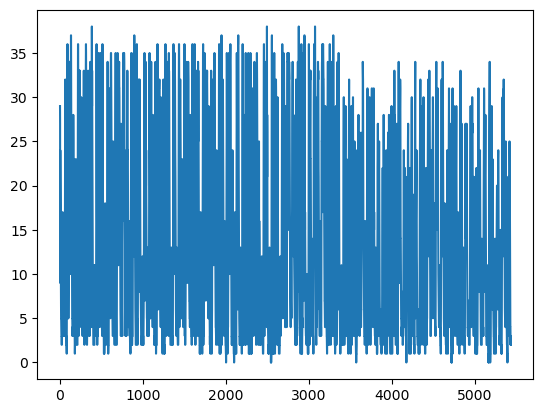

In [520]:
plt.plot(mvt)

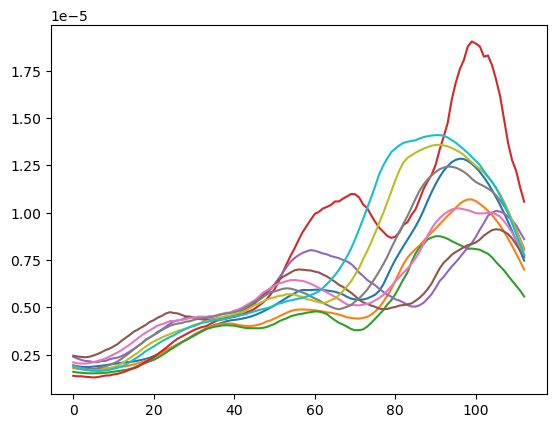

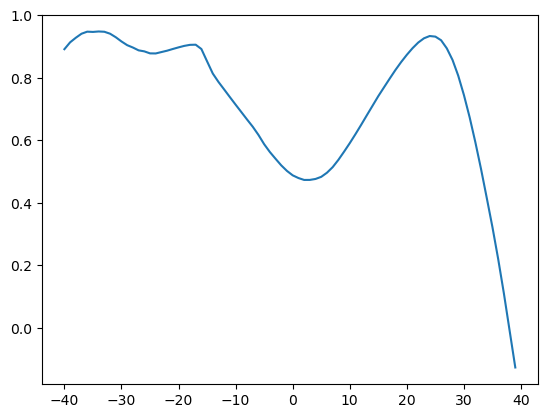

In [386]:
plt.plot(all_shifts[4*nb_gating_spokes],all_correls[4*nb_gating_spokes])



In [370]:
all_shifts[136*nb_gating_spokes][np.argmax(all_correls[136*nb_gating_spokes])]

-4

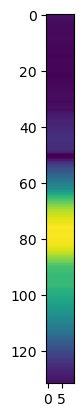

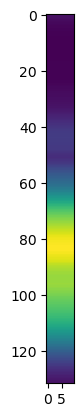

In [371]:
plt.imshow(np.repeat(image_nav_adj[136][0],10).reshape(-1,10))
plt.figure()
plt.imshow(np.repeat(ft[0],10).reshape(-1,10))

In [372]:
displacement[136*nb_gating_spokes]

29

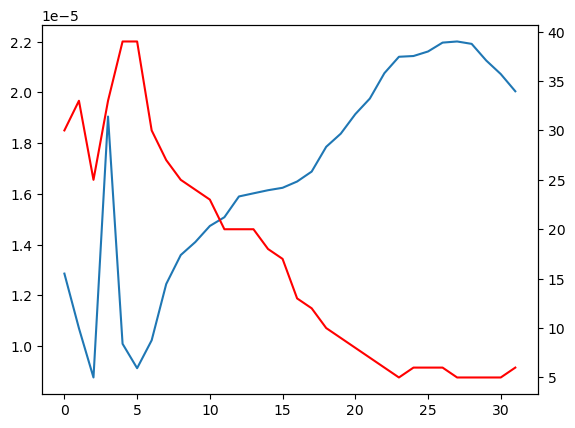

In [406]:
max_correls=np.array(max_correls)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(max_correls[disp_start:disp_end])
ax2.plot(mvt[disp_start:disp_end],c="red")

In [521]:
displacement = np.array(mvt)
max_correls=np.array(max_correls)
if dct_frequency_filter is not None:
    displacements_reshaped = displacement.reshape(nb_slices, nb_gating_spokes)
    displacements_smooth = np.zeros_like(displacements_reshaped)
    for sl in range(nb_slices):
        transf_disp = sp.fft.dct(displacements_reshaped[sl])
        transf_disp[-dct_frequency_filter:] = 0
        displacements_smooth[sl] = sp.fft.idct(transf_disp)
    displacement = displacements_smooth.flatten()


In [522]:
max_correl_for_interp

In [523]:
max_correl_for_interp=None
if max_correl_for_interp is not None:
    ind_bad_correl=np.argwhere(max_correls<max_correl_for_interp)
    displacement_new=copy(displacement)
    for i in ind_bad_correl.flatten():
        if ((np.abs(displacement[i]-displacement[i-1])/np.abs(displacement[i])>0.5)and(np.abs(displacement[i]-displacement[i+1])/np.abs(displacement[i])>0.5)):
            displacement_new[i]=np.mean([displacement[i-1],displacement[i+1]])


In [377]:
disp_start/nb_gating_spokes

136.0

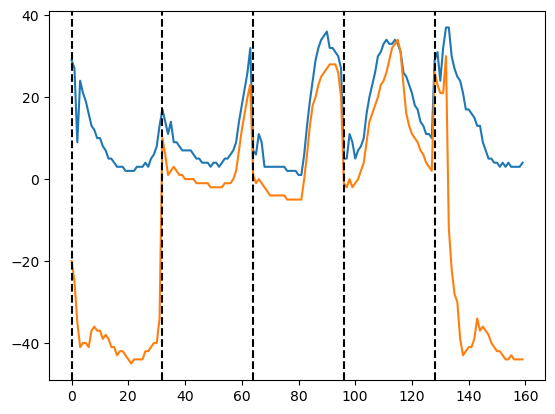

In [524]:
start_cycle=np.random.randint(0,nb_slices)
start_cycle=0
# start_cycle=136
nb_cycles=5
disp_start=start_cycle*nb_gating_spokes
disp_end=disp_start+nb_cycles*nb_gating_spokes

plt.plot(displacement[disp_start:disp_end])
# plt.plot(displacement_new[disp_start:disp_end])
plt.plot(disp[disp_start:disp_end])
for j in range(nb_cycles):
    plt.axvline(j*nb_gating_spokes, color='k', linestyle='--')

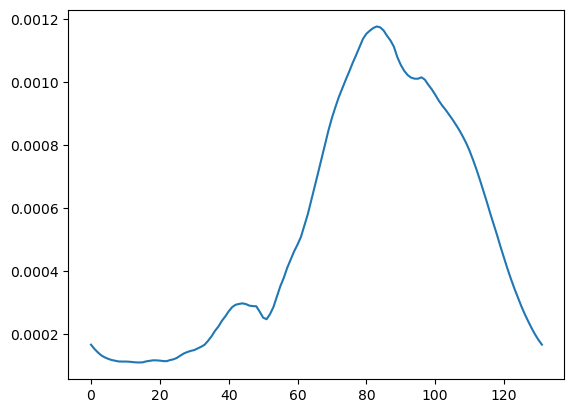

In [414]:
plt.plot(ft[0,:])

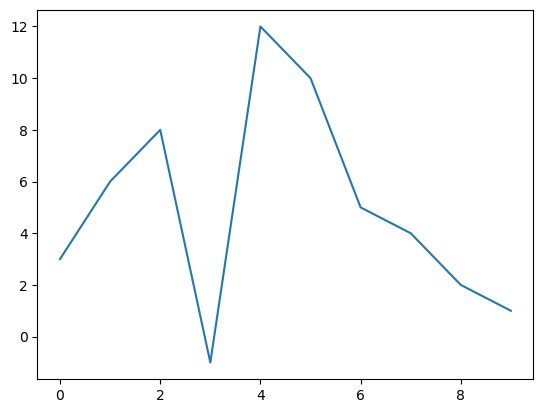

In [472]:
plt.plot(displacement[:10])

In [487]:
image_nav_adj[0][:nb_spokes].shape

(10, 132)

In [489]:
np.repeat(image_nav_adj[0][:nb_spokes],10,axis=0).shape

(100, 132)

In [499]:
image_nav_adj_norm=image_nav_adj/np.max(image_nav_adj,axis=-1,keepdims=1)

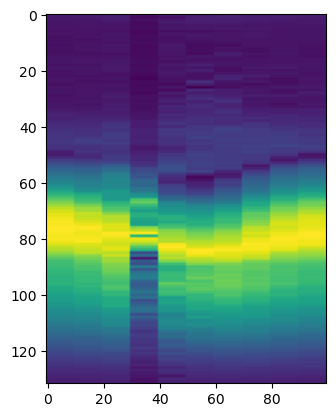

In [502]:
nb_spokes=10
cycle=np.random.randint(0,nb_slices)
plt.imshow(np.repeat(image_nav_adj_norm[cycle][:nb_spokes],repeats=10,axis=0).T)

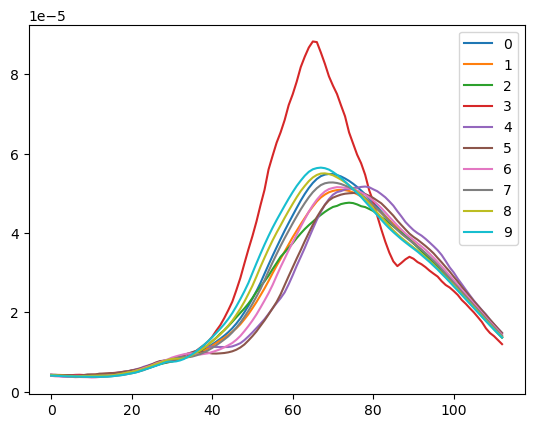

In [473]:
for j in range(10):
    plt.plot(all_correls[j],label=j)
plt.legend()

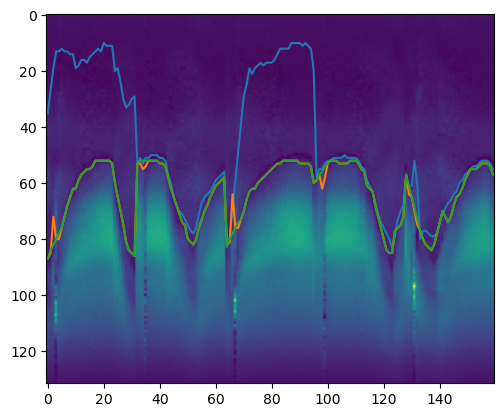

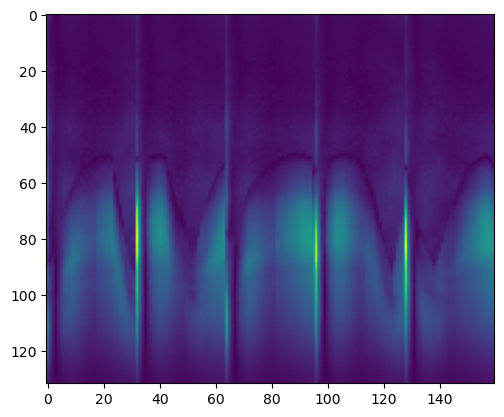

In [532]:
start_cycle=np.random.randint(0,nb_slices)
# start_cycle=0
nb_cycles=5
disp_start=start_cycle*nb_gating_spokes
disp_end=disp_start+nb_cycles*nb_gating_spokes

plt.imshow(np.abs(image_nav_adj.reshape(-1,npoint_nav)[disp_start:disp_end]).T)
plt.plot(55+disp[disp_start:disp_end])
plt.plot(50+displacement[disp_start:disp_end])
plt.plot(50+displacement_new[disp_start:disp_end])

plt.figure()
plt.imshow(np.abs(image_nav[ch].reshape(-1,npoint_nav)[disp_start:disp_end]).T)

In [525]:
disp_interp=copy(displacement).reshape(-1,nb_gating_spokes)
disp_interp[:, :6] = ((disp_interp[:, 5] - disp_interp[:, 0]) / (5 - 0))[:, None] * np.arange(6)[None,
                                                                                            :] + disp_interp[:, 0][:,
                                                                                                 None]
displacement_new = disp_interp.flatten()

In [526]:
displacement.shape

(5440,)